# BUSCANDO INDICADORES DE RETENCIONES DE TRÁFICO EN LA I-94

Vamos a estudiar el tráfico de la carretera Interestatal I-94, una autopista interestatal de dirección este-oeste que conecta las regiones de los Grandes Lagos y las Grandes Llanuras del norte de los Estados Unidos de América.

https://en.wikipedia.org/wiki/Interstate_94

<img src="https://i.imgur.com/IU9ru3C.png">

*Fuente:wikipedia*

## OBJETIVOS

Queremos determinar algunos indicadores que producen grandes volúmenes de tráfico en la I-94. Estos indicadores pueden ser de tipo climático, de tipo horario, incidentes, etc. Por ejemplo, normalmente el tráfico es más intenso entre semana que en fines de semana.

Para ello, vamos a analizar un dataset que contiene datos sobre el tráfico de la parte Oeste de la autopista I-94.

## EL DATASET

El dataset es público y fue creado por John Hogue, y está disponible en UCI Machine Learning Repository:

https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

Vamos a leer el dataset, y a visualizar unas pequeñas muestras para echar un primer vistazo:

In [1]:
import pandas as pd

i94 = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

In [2]:
i94.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
i94.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


### Información que nos proporciona el dataset

De acuerdo con la documentación del dataset, los datos fueron recogidos por la estación ATR 301, que se encuentra entre Minneapolis y St.Paul,MN, en sentido oeste.

Por lo tanto, los datos que tenemos en el dataset son del tramo de la I-94 en el estado de Minnesota que conecta Minneapolis con St.Paul, en sentido oeste.

<img src="https://s3.amazonaws.com/dq-content/524/i94_figma.png">

In [4]:
i94.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


El dataset (al que hemos llamado *i94*) contiene 48.204 filas y 9 columnas. La descripción de las columnas, según la documentación del dataset, es la siguiente:

- **holiday:** Día festivo/no festivo (Festivos nacionales + Festivos regionales)
- **temp:** Temperatura media en kelvin (K)
- **rain_1h:** Cantidad numérica en mm de lluvia acumulada en la última hora
- **snow_1h:** Cantidad numérica en mm de nieve acumulada en la última hora
- **clouds_all:** Porcentaje numérico de nubosidad
- **weather_main:** Breve descripición textual del clima en ese momento
- **weather_description:** Descripción algo más detallada del clima en ese momento
- **date_time:** Hora de recolección de los datos en hora local CST
- **traffic_volume:** Volumen de tráfico numérico reportado en la última hora en I-94 ATR 301 westbound

## PRIMERAS VISUALIZACIONES DE LOS REGISTROS DEL TRÁFICO

Vamos a ver de una manera generalizada la distribución del tráfico, según la columna 'traffic_volume' del dataset:

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

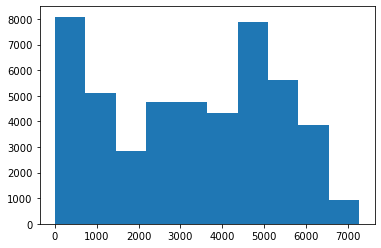

In [6]:
plt.hist(i94['traffic_volume'])
plt.show()

El gráfico muestra la distribución del tráfico en 10 intervalos iguales. La distribución parece bastante uniforme, lo que quiere decir que el tráfico numérico, en principio y a grandes rasgos, parece bastante constante.

In [7]:
i94['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

En los 48204 registros distintos que tenemos, la media de vehículos por hora que circularon en nuestro tramo fue de 3259, con unos valores máximos de 7280 vehículos por hora.

El 25% del tiempo, los vehículos que cicularon fueron 1193, mientras que otro 25% del tiempo (75% en la lista) fueron 4933, más del cuádruple. Esto nos lleva a pensar que quizás el primer 25% agrupa las horas nocturnas, mientras que el segundo agrupa horas diurnas (cuando en teoría el tráfico es más intenso).

## COMPARANDO EL TRÁFICO DIURNO CON EL TRÁFICO NOCTURNO

Vamos a dividir las horas del día en dos tramos horarios de 12 horas cada uno: horas diurnas y horas nocturnas.

- **Horas diurnas:** 07:00h - 19:00h 
- **Horas nocturnas:** 19:00h - 07:00h

Aunque no es un criterio perfecto para distinguir el horario diurno con el nocturno, creemos que es un buen punto de partida.

In [8]:
# Primero, hay que cambiar el datatype de la columna 'date_time' a tipo datetime
i94['date_time'] = pd.to_datetime(i94['date_time'])

In [9]:
i94['date_time'].describe(datetime_is_numeric=True)

count                            48204
mean     2016-01-05 10:46:16.773711616
min                2012-10-02 09:00:00
25%                2014-02-06 11:45:00
50%                2016-06-11 03:30:00
75%                2017-08-11 06:00:00
max                2018-09-30 23:00:00
Name: date_time, dtype: object

In [10]:
horas_dt = i94['date_time'].dt.hour

Vamos a aislar los datos de las horas nocturnas y las diurnas:

In [11]:
import datetime as dt

In [12]:
diurnas = i94[(i94['date_time'].dt.hour >= 7) & (i94['date_time'].dt.hour <= 18)]

In [13]:
diurnas.value_counts()

holiday  temp    rain_1h  snow_1h  clouds_all  weather_main  weather_description  date_time            traffic_volume
None     295.77  0.0      0.0      75          Clouds        broken clouds        2017-06-30 12:00:00  5229              2
         296.95  0.0      0.0      1           Thunderstorm  thunderstorm         2017-06-30 13:00:00  5263              2
         289.06  0.0      0.0      90          Clouds        overcast clouds      2016-06-01 10:00:00  4831              2
         292.84  0.0      0.0      1           Clear         sky is clear         2017-06-30 10:00:00  4638              2
         267.89  0.0      0.0      90          Snow          light snow           2016-12-06 18:00:00  4520              2
                                                                                                                        ..
         275.29  0.0      0.0      90          Snow          snow                 2015-12-16 10:00:00  4593              1
                     

In [14]:
nocturnas = i94[(i94['date_time'].dt.hour >= 8) & (i94['date_time'].dt.hour >= 19)]

In [15]:
# Mostramos la cabecera de las horas diurnas
diurnas.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [16]:
# Mostramos la cabecera de las horas nocturnas
nocturnas.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
10,None,290.97,0.0,0.0,20,Clouds,few clouds,2012-10-02 19:00:00,3539
11,None,289.38,0.0,0.0,1,Clear,sky is clear,2012-10-02 20:00:00,2784
12,None,288.61,0.0,0.0,1,Clear,sky is clear,2012-10-02 21:00:00,2361
13,None,287.16,0.0,0.0,1,Clear,sky is clear,2012-10-02 22:00:00,1529
14,None,285.45,0.0,0.0,1,Clear,sky is clear,2012-10-02 23:00:00,963


Ahora tenemos dos DataFrames, uno con las horas diurnas y otro con las horas nocturnas. Vamos a comparar el volumen del tráfico en cada uno de los casos:

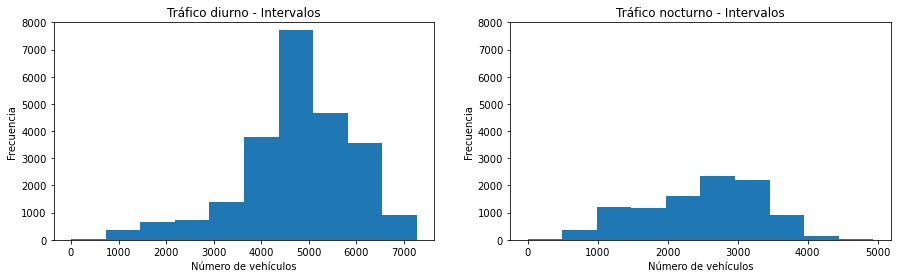

In [17]:
plt.figure(figsize=(15,4))
# Histograma tráfico diurno
plt.subplot(1,2,1)
plt.hist(diurnas['traffic_volume'])
plt.title('Tráfico diurno - Intervalos')
plt.ylim([0,8000])
plt.xlabel('Número de vehículos')
plt.ylabel('Frecuencia')

# Histograma tráfico nocturno
plt.subplot(1,2,2)
plt.hist(nocturnas['traffic_volume'])
plt.title('Tráfico nocturno - Intervalos')
plt.ylim([0,8000])
plt.xlabel('Número de vehículos')
plt.ylabel('Frecuencia')

# Mostramos los histogramas
plt.show()

Se puede distinguir claramente que por el día el tráfico es más intenso. Un día típico, circulan entre 4.000 y 7.000 vehículos por hora, mientras que por la noche la distribución es mucho más uniforme, entre 1.000 y 3.500 vehículos.

Vamos a ver esto en profundidad:

In [18]:
diurnas['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

El tráfico diurno nos ofrece los siguientes datos:

- La media de vehículos por hora fue de 4.762
- La cantidad de vehículos por hora se mantiene muy consistente entre 4.252 y 7.280

In [19]:
nocturnas['traffic_volume'].describe()

count    9956.000000
mean     2481.649960
std       823.594024
min         0.000000
25%      1870.000000
50%      2617.000000
75%      3112.000000
max      4939.000000
Name: traffic_volume, dtype: float64

Tráfico nocturno:

- La media de vehículos por hora fue de 2.481, prácticamente la mitad que los vehículos en el periodo diurno
- El flujo de vehículos es dispar, entre 1.870 y 3.112

Si agregásemos las 19.00h al tramo diurno, las diferencias en cuanto a volumen de tráfico serían incluso más abultadas, pero con lo que tenemos, es suficiente para comprobar que el tráfico diurno es mucho más intenso que por la noche.

Como el tráfico es más intenso de día, y lo que buscamos son indicadores de aumento del volumen de tráfico, trabajaremos con el dataset de horas diurnas al tener mucho más volumen de tráfico.

## VOLUMEN DE TRÁFICO POR MESES 

Vamos a seguir explorando el volumen del tráfico, esta vez mensualmente. Queremos comprobar si hay meses en los que el tráfico sea especialmente intenso, o especialmente ligero. Como hemos comentado, utilizaremos los datos de las horas diurnas:

In [20]:
# Esta línea de código evita un copyWarning de pandas
pd.options.mode.chained_assignment = None

# Agrupamos por la media mensual de vehículos
diurnas['month'] = diurnas['date_time'].dt.month
por_mes = diurnas.groupby('month').mean()
por_mes['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

La media de vehículos al mes se mantiene por encima de los 4.000 vehículos/hora. Vamos a verlo gráficamente:

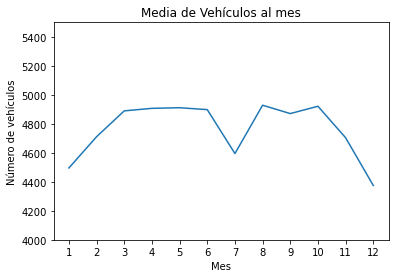

In [21]:
plt.plot(por_mes['traffic_volume'])
plt.title('Media de Vehículos al mes')
plt.xlabel('Mes')
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
           labels=[1,2,3,4,5,6,7,8,9,10,11,12])
plt.ylabel('Número de vehículos')
plt.ylim([4000,5500])
plt.show()

Vemos que hay una reducción significativa del tráfico en los meses de invierno (de octubre a marzo); en julio también cae el volumen (aunque no de manera tan pronunciada).

**La media de vehículos en los meses de invierno es:**

In [22]:
round(por_mes['traffic_volume'].loc[[1,2,11,12]].mean())

4571

**La media de vehículos en los meses restantes es:**

In [23]:
round(por_mes['traffic_volume'].loc[[3,4,5,6,8,9,10]].mean())

4904

**El volumen del tráfico de los meses de invierno respecto a lo meses de verano es:**

In [24]:
print(f"{100*round(4571/4904,2)} %")

93.0 %


**El volumen del tráfico en julio respecto a los demás meses (excluyendo los meses invernales) es:**

In [25]:
print(f"{100*round(4595/4904,2)} %")

94.0 %


## VOLUMEN DE TRÁFICO POR DÍAS DE LA SEMANA

Vamos a hacer la misma operación que acabamos de realizar con los meses, pero esta vez con los días de la semana.

Agrupamos el volumen del tráfico por días de la semana, para ver la media de vehículos que circulan cada día:

In [26]:
diurnas['dayofweek'] = diurnas['date_time'].dt.dayofweek
por_dayofweek = diurnas.groupby('dayofweek').mean()
por_dayofweek['traffic_volume']

dayofweek
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

Los días de la semana vienen dados como un número del 0 al 6, donde 0 es lunes y 6 es domingo.

Hay una evidente reducción de volumen del tráfico los sábados y domingos. 

El día laborable con menos tráfico es el lunes, y los demás días tienen un tráfico muy consistente y similar.

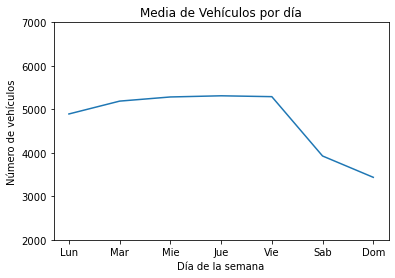

In [27]:
# Creamos un gráfico para facilitar la visualización
plt.plot(por_dayofweek['traffic_volume'])
plt.title('Media de Vehículos por día')
plt.xlabel('Día de la semana')
plt.xticks(ticks=[0,1,2,3,4,5,6],
           labels=['Lun','Mar','Mie','Jue','Vie','Sab','Dom'])
plt.ylabel('Número de vehículos')
plt.ylim([2000,7000])
plt.show()

La reducción del volumen del tráfico los días no laborables se ve de manera muy evidente en el gráfico que acabamos de mostrar. 

Media del volumen de tráfico los días laborables:

In [28]:
print(round(por_dayofweek['traffic_volume'].loc[[0,1,2,3,4]].mean()))

5194


**El volumen del tráfico los días no-laborables respecto a los días laborables es:**

In [29]:
print(f"{round(100*((3927+3436)/2)/5194)} %")

71 %


## VOLUMEN DEL TRÁFICO POR HORAS DEL DÍA

Vamos a dividir el dataset de horas diurnas en dos partes: 

- Una parte serán los días laborables
- La otra los no laborables

Lo hacemos de esta manera ya que hay bastante diferencia en el volumen del tráfico entre las partes.

In [30]:
diurnas['hour'] = diurnas['date_time'].dt.hour
# Creamos las dos partes 
laborables = diurnas.copy()[diurnas['dayofweek'] <= 4] # 4 es viernes
no_laborables = diurnas.copy()[diurnas['dayofweek'] >= 5] # 5 es sábado
# Agrupamos por horas
horas_laborables = laborables.groupby('hour').mean()
horas_no_laborables = no_laborables.groupby('hour').mean()
# Imprimimos los resultados
print(horas_laborables['traffic_volume'])
print(horas_no_laborables['traffic_volume'])

hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


Se puede ver que el tráfico es más intenso los días laborables, sobre todo por las mañanas. Vamos a verlo de forma gráfica para visualizarlo mejor:

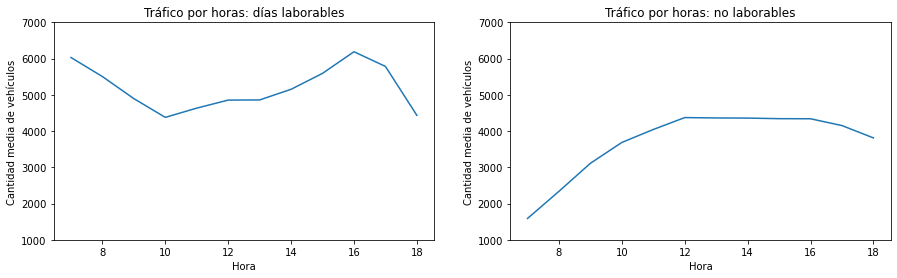

In [31]:
# Creamos un gráfico de cuadrículas; hay que cambiar el tamaño por defecto para una correcta visualización
plt.figure(figsize=(15,4))

# Volumen por horas: días laborables. Primer subplot
plt.subplot(1,2,1)
plt.plot(horas_laborables['traffic_volume'])
plt.title('Tráfico por horas: días laborables')
plt.xlabel('Hora')
plt.ylabel('Cantidad media de vehículos')
plt.ylim([1000,7000])

# Volumen por horas: fin de semana. Segundo subplot
plt.subplot(1,2,2)
plt.plot(horas_no_laborables['traffic_volume'])
plt.title('Tráfico por horas: no laborables')
plt.xlabel('Hora')
plt.ylabel('Cantidad media de vehículos')
plt.ylim([1000,7000])

plt.show()

### Horas punta: días laborables:

- Los días laborables, la mayor cantidad de tráfico se concentra a las 7:00h y a las 16:00h, aproximadamente.

- Las horas valle abarcan desde las 9:00h hasta las 14:00h, aproximadamente.

### Horas punta: días no-laborables:

- Los días no-laborables, el volumen del tráfico es bastante constante entre las 12:00h y las 17:00h. 

- A primera hora de la mañana, el volumen del tráfico es muy poco intenso.

## VOLUMEN DEL TRÁFICO SEGÚN EL CLIMA

La estación de la I-94 donde se recopilaron los datos que estamos analizando, está en un punto entre las ciudades de St.Paul y Minneapolis, en el estado de Minnesota. St.Paul forma parte del Área Metropolitana de Minneápolis.

Las temperaturas medias de Minneápolis oscilan entre los -10ºC en invierno, y los 20ºC en verano. Los meses más lluviosos comprenden el periodo de Abril a Octubre; en este periodo, los mm de lluvias son más del doble que en Londres (UK), siendo Minneápolis una ciudad donde la lluvia es algo bastante frecuente.

Entre diciembre y marzo (meses de invierno), la media de nieve oscila entre 50mm y 100mm.

Minneápolis es la capital más fría de EEUU, teniendo la mayor cantidad de días anuales por debajo de 0ºC, y las temperaturas medias anuales más bajas.

Por todo esto, el clima puede ser un factor determinante a la hora de medir el volumen del tráfico en Minneápolis.

<img src="https://www.imago-images.com/bild/st/0067535330/w.jpg">

*Imagen del tramo que estamos analizando, cerca de Minnesotta, un viernes por la mañana*

### Correlación entre el clima y el volumen del tráfico

Atendiendo a la descripción de las columnas del dataset, las que muestran datos numéricos sobre el clima son las siguientes:

- **temp:** Temperatura media en kelvin (K)
- **rain_1h:** Cantidad numérica en mm de lluvia acumulada en la última hora
- **snow_1h:** Cantidad numérica en mm de nieve acumulada en la última hora

Como ahora estamos analizando las horas de mayor intensidad (periodo diurno de los días laborables), vamos a buscar si existe una fuerte correlación entre alguno de estos indicadores y el volumen del tráfico.

In [32]:
clima_num = laborables[['temp','rain_1h','snow_1h','traffic_volume']]

In [33]:
clima_num.corr()['traffic_volume']

temp              0.139999
rain_1h           0.002728
snow_1h          -0.008016
traffic_volume    1.000000
Name: traffic_volume, dtype: float64

El único indicador que tiene algo de correlación con el volumen del tráfico es la temperatura (14%).

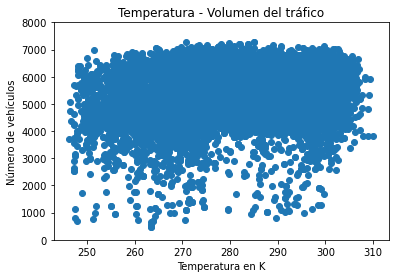

In [34]:
# Creamos un gráfico de dispersión para verlo con más claridad
plt.scatter(clima_num['temp'], clima_num['traffic_volume'])
plt.title('Temperatura - Volumen del tráfico')
plt.xlabel('Temperatura en K')
plt.ylabel('Número de vehículos')
plt.ylim([0,8000])
plt.show()

**No hay una relación clara entre la temperatura y el número de vehículos. La masa de tráfico se mantiene independiente de la temperatura.**

## VOLUMEN  DEL TRÁFICO: CLIMA DE MANERA CATEGÓRICA

Las columnas 'weather_main' y 'weather_description' nos ofrecen una descripción categórica de la situación climática en el momento de las mediciones del volumen del tráfico.

Vamos a calcular la media de vehículos asociada a cada valor único de las dos columnas.

In [35]:
# Agrupamos por las medias del clima
por_clima_main = diurnas.groupby('weather_main').mean()
por_clima_desc = diurnas.groupby('weather_description').mean()

### Análisis por clima genérico

In [36]:
por_clima_main

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month,dayofweek,hour
weather_main,,,,,,,,
Clear,283.812078,0.000000,0.000000,1.670265,4778.416260,6.490599,3.138928,12.404248
Clouds,282.929274,0.000000,0.000000,62.667548,4865.415996,6.393243,3.005631,12.911974
Drizzle,284.456433,0.170804,0.000000,84.704417,4837.212911,7.105323,2.934315,12.308041
Fog,277.579641,0.163840,0.001409,65.477901,4372.491713,6.646409,2.798343,10.325967
Haze,275.319353,0.040036,0.000000,64.000000,4609.893285,5.832134,2.754197,12.467626
Mist,279.420825,0.249992,0.000825,74.961435,4623.976475,6.734285,2.895102,11.078288
Rain,287.089601,3.972943,0.000292,75.870116,4815.568462,6.774023,2.914467,12.642379
Smoke,292.405833,0.878333,0.000000,53.333333,4564.583333,6.833333,2.416667,13.166667
Snow,267.984505,0.014017,0.001768,80.501376,4396.321183,6.374828,2.750344,12.153370


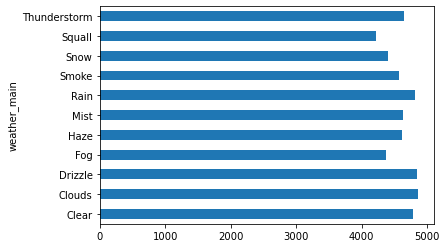

In [37]:
# Graficamos esto para visualizarlo mejor
por_clima_main['traffic_volume'].plot.barh()
plt.show()

Parece ser que 'lluvia', 'llovizna' y 'nubes' causan más tráfico que los demás estados climáticos. Vamos a ver en detalle cada estado climático:

### Análisis por clima detallado

In [38]:
por_clima_desc

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month,dayofweek,hour
weather_description,,,,,,,,
SQUALLS,296.730000,1.020000,0.000000,75.000000,4211.000000,7.000000,2.000000,14.000000
Sky is Clear,293.232549,0.000000,0.000000,0.000000,4919.009390,7.557512,2.895540,12.453052
broken clouds,282.372927,0.000000,0.000000,72.635875,4824.130326,6.675260,2.998210,12.811314
drizzle,283.573777,0.145072,0.000000,88.589928,4737.330935,7.244604,3.028777,11.697842
few clouds,284.272965,0.000000,0.000000,19.391951,4839.818023,6.159230,2.977253,12.633421
fog,277.579641,0.163840,0.001409,65.477901,4372.491713,6.646409,2.798343,10.325967
freezing rain,272.860000,0.000000,0.000000,90.000000,4314.000000,6.500000,0.500000,13.500000
haze,275.319353,0.040036,0.000000,64.000000,4609.893285,5.832134,2.754197,12.467626
heavy intensity drizzle,285.467931,0.276207,0.000000,89.172414,4738.586207,7.551724,2.896552,12.275862


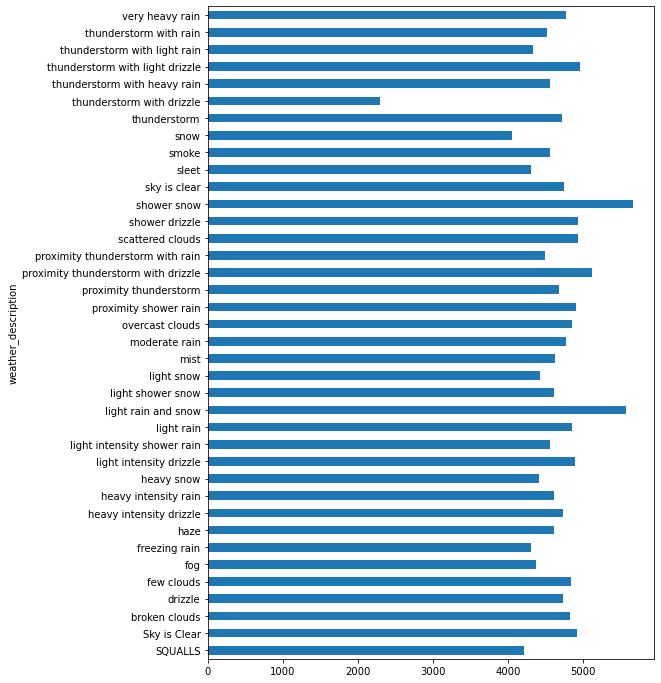

In [39]:
# De nuevo, lo mostramos gráficamente
plt.figure(figsize=(8,12))
por_clima_desc['traffic_volume'].plot.barh()
plt.show()

Aquí sí que vemos con claridad que 'Shower snow' (nevada fuerte) y 'Lluvia ligera y nieve' causan más tráfico que los demás estados.

Además, 'Tormenta eléctrica con llovizna' sorprende por tener prácticamente la mitad del volumen normal de tráfico.

# CONCLUSIONES FINALES

El dataset tampoco nos ofrece mucha más información que podamos analizar. Hemos estudiado la relación del volumen del tráfico con todas las variables posibles, y las conclusiones que hemos sacado son las siguientes:


**Volumen del tráfico: tramos diarios:**

- Durante las horas diurnas (7:00h-18-00h), el tráfico es mucho más intenso que por la noche (19:00h-06:00h)

**Volumen del tráfico: tramos semanales:**

- El volumen del tráfico es menor los días no-laborables, concretamente el volumen medio respecto a los laborables es del 71%
- Las horas de mayor tráfico son:
    - Para los días laborables:
        - Las horas punta son las 7:00h y las 16:00h, con 6.030 y 6.189 vehículos por hora, de media.
    - Para los días no-laborables:
        - Las horas de mayor tráfico comprenden entre las 12:00h y las 17:00h, con un volumen consante de unos 4.000 vehículos.

**Volumen del tráfico: tramos anuales:**

- El volumen del tráfico es significativamente menos intenso en los meses de invierno y en julio. En concreto:
    - En el periodo de octubre a marzo el volumen del tráfico es un 7% menor que en el resto de los meses hábiles
    - En julio el volumen del tráfico es un 6% menor que en los meses hábiles, excluyendo los meses invernales
    
**Volumen del tráfico: cambios en el volumen en relación a la climatología:**

- Cuando hay nevadas fuertes, y lluvia ligera y nieve, el volumen del tráfico aumenta hasta casi los 6.000 vehículos por hora, mientras que no sobrepasa los 5.000 vehículos en los demás estados climatológicos.
- Cuando hay tormenta eléctrica, el volumen del tráfico cae drásticamente hasta aproximadamente los 2.500 vehículos por hora, prácticamente la mitad de la media habitual.